In [1]:
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
import torch
import torch.nn as nn
from functools import partial
from torch import Tensor
from typing import Optional

from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_, lecun_normal_

from timm.models.layers import DropPath, to_2tuple
from timm.models.vision_transformer import _load_weights

import math

from collections import namedtuple

from mamba_ssm.modules.mamba_simple import Mamba
from mamba_ssm.utils.generation import GenerationMixin
from mamba_ssm.utils.hf import load_config_hf, load_state_dict_hf

from rope import *
import random

try:
    from mamba_ssm.ops.triton.layernorm import RMSNorm, layer_norm_fn, rms_norm_fn
except ImportError:
    RMSNorm, layer_norm_fn, rms_norm_fn = None, None, None


__all__ = [
    'vim_tiny_patch16_224', 'vim_small_patch16_224', 'vim_base_patch16_224',
    'vim_tiny_patch16_384', 'vim_small_patch16_384', 'vim_base_patch16_384',
]


class PatchEmbed(nn.Module):
    """ 2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, stride=16, in_chans=3, embed_dim=768, norm_layer=None, flatten=True):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = ((img_size[0] - patch_size[0]) // stride + 1, (img_size[1] - patch_size[1]) // stride + 1)
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x
    

class Block(nn.Module):
    def __init__(
        self, dim, mixer_cls, norm_cls=nn.LayerNorm, fused_add_norm=False, residual_in_fp32=False,drop_path=0.,
    ):
        """
        Simple block wrapping a mixer class with LayerNorm/RMSNorm and residual connection"

        This Block has a slightly different structure compared to a regular
        prenorm Transformer block.
        The standard block is: LN -> MHA/MLP -> Add.
        [Ref: https://arxiv.org/abs/2002.04745]
        Here we have: Add -> LN -> Mixer, returning both
        the hidden_states (output of the mixer) and the residual.
        This is purely for performance reasons, as we can fuse add and LayerNorm.
        The residual needs to be provided (except for the very first block).
        """
        super().__init__()
        self.residual_in_fp32 = residual_in_fp32
        self.fused_add_norm = fused_add_norm
        self.mixer = mixer_cls(dim)
        self.norm = norm_cls(dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        if self.fused_add_norm:
            assert RMSNorm is not None, "RMSNorm import fails"
            assert isinstance(
                self.norm, (nn.LayerNorm, RMSNorm)
            ), "Only LayerNorm and RMSNorm are supported for fused_add_norm"

    def forward(
        self, hidden_states: Tensor, residual: Optional[Tensor] = None, inference_params=None
    ):
        r"""Pass the input through the encoder layer.

        Args:
            hidden_states: the sequence to the encoder layer (required).
            residual: hidden_states = Mixer(LN(residual))
        """
        if not self.fused_add_norm:
            if residual is None:
                residual = hidden_states
            else:
                residual = residual + self.drop_path(hidden_states)
            
            hidden_states = self.norm(residual.to(dtype=self.norm.weight.dtype))
            if self.residual_in_fp32:
                residual = residual.to(torch.float32)
        else:
            fused_add_norm_fn = rms_norm_fn if isinstance(self.norm, RMSNorm) else layer_norm_fn
            if residual is None:
                hidden_states, residual = fused_add_norm_fn(
                    hidden_states,
                    self.norm.weight,
                    self.norm.bias,
                    residual=residual,
                    prenorm=True,
                    residual_in_fp32=self.residual_in_fp32,
                    eps=self.norm.eps,
                )
            else:
                hidden_states, residual = fused_add_norm_fn(
                    self.drop_path(hidden_states),
                    self.norm.weight,
                    self.norm.bias,
                    residual=residual,
                    prenorm=True,
                    residual_in_fp32=self.residual_in_fp32,
                    eps=self.norm.eps,
                )    
        hidden_states = self.mixer(hidden_states, inference_params=inference_params)
        return hidden_states, residual

    def allocate_inference_cache(self, batch_size, max_seqlen, dtype=None, **kwargs):
        return self.mixer.allocate_inference_cache(batch_size, max_seqlen, dtype=dtype, **kwargs)


def create_block(
    d_model,
    ssm_cfg=None,
    norm_epsilon=1e-5,
    drop_path=0.,
    rms_norm=False,
    residual_in_fp32=False,
    fused_add_norm=False,
    layer_idx=None,
    device=None,
    dtype=None,
    if_bimamba=False,
    bimamba_type="none",
    if_devide_out=False,
    init_layer_scale=None,
):
    if if_bimamba:
        bimamba_type = "v1"
    if ssm_cfg is None:
        ssm_cfg = {}
    factory_kwargs = {"device": device, "dtype": dtype}
    mixer_cls = partial(Mamba, layer_idx=layer_idx, bimamba_type=bimamba_type, if_devide_out=if_devide_out, init_layer_scale=init_layer_scale, **ssm_cfg, **factory_kwargs)
    norm_cls = partial(
        nn.LayerNorm if not rms_norm else RMSNorm, eps=norm_epsilon, **factory_kwargs
    )
    block = Block(
        d_model,
        mixer_cls,
        norm_cls=norm_cls,
        drop_path=drop_path,
        fused_add_norm=fused_add_norm,
        residual_in_fp32=residual_in_fp32,
    )
    block.layer_idx = layer_idx
    return block


# https://github.com/huggingface/transformers/blob/c28d04e9e252a1a099944e325685f14d242ecdcd/src/transformers/models/gpt2/modeling_gpt2.py#L454
def _init_weights(
    module,
    n_layer,
    initializer_range=0.02,  # Now only used for embedding layer.
    rescale_prenorm_residual=True,
    n_residuals_per_layer=1,  # Change to 2 if we have MLP
):
    if isinstance(module, nn.Linear):
        if module.bias is not None:
            if not getattr(module.bias, "_no_reinit", False):
                nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, std=initializer_range)

    if rescale_prenorm_residual:
        # Reinitialize selected weights subject to the OpenAI GPT-2 Paper Scheme:
        #   > A modified initialization which accounts for the accumulation on the residual path with model depth. Scale
        #   > the weights of residual layers at initialization by a factor of 1/√N where N is the # of residual layers.
        #   >   -- GPT-2 :: https://openai.com/blog/better-language-models/
        #
        # Reference (Megatron-LM): https://github.com/NVIDIA/Megatron-LM/blob/main/megatron/model/gpt_model.py
        for name, p in module.named_parameters():
            if name in ["out_proj.weight", "fc2.weight"]:
                # Special Scaled Initialization --> There are 2 Layer Norms per Transformer Block
                # Following Pytorch init, except scale by 1/sqrt(2 * n_layer)
                # We need to reinit p since this code could be called multiple times
                # Having just p *= scale would repeatedly scale it down
                nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                with torch.no_grad():
                    p /= math.sqrt(n_residuals_per_layer * n_layer)


def segm_init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)


class VisionMamba(nn.Module):
    def __init__(self, 
                 img_size=224, 
                 patch_size=16, 
                 stride=16,
                 depth=24, 
                 embed_dim=192, 
                 channels=3, 
                 num_classes=1000,
                 ssm_cfg=None, 
                 drop_rate=0.,
                 drop_path_rate=0.1,
                 norm_epsilon: float = 1e-5, 
                 rms_norm: bool = False, 
                 initializer_cfg=None,
                 fused_add_norm=False,
                 residual_in_fp32=False,
                 device=None,
                 dtype=None,
                 ft_seq_len=None,
                 pt_hw_seq_len=14,
                 if_bidirectional=False,
                 final_pool_type='none',
                 if_abs_pos_embed=False,
                 if_rope=False,
                 if_rope_residual=False,
                 flip_img_sequences_ratio=-1.,
                 if_bimamba=False,
                 bimamba_type="none",
                 if_cls_token=False,
                 if_devide_out=False,
                 init_layer_scale=None,
                 use_double_cls_token=False,
                 use_middle_cls_token=False,
                 **kwargs):
        factory_kwargs = {"device": device, "dtype": dtype}
        # add factory_kwargs into kwargs
        kwargs.update(factory_kwargs) 
        super().__init__()
        self.residual_in_fp32 = residual_in_fp32
        self.fused_add_norm = fused_add_norm
        self.if_bidirectional = if_bidirectional
        self.final_pool_type = final_pool_type
        self.if_abs_pos_embed = if_abs_pos_embed
        self.if_rope = if_rope
        self.if_rope_residual = if_rope_residual
        self.flip_img_sequences_ratio = flip_img_sequences_ratio
        self.if_cls_token = if_cls_token
        self.use_double_cls_token = use_double_cls_token
        self.use_middle_cls_token = use_middle_cls_token
        self.num_tokens = 1 if if_cls_token else 0

        # pretrain parameters
        self.num_classes = num_classes
        self.d_model = self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, stride=stride, in_chans=channels, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        if if_cls_token:
            if use_double_cls_token:
                self.cls_token_head = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
                self.cls_token_tail = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
                self.num_tokens = 2
            else:
                self.cls_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
                # self.num_tokens = 1
            
        if if_abs_pos_embed:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, self.embed_dim))
            self.pos_drop = nn.Dropout(p=drop_rate)

        if if_rope:
            half_head_dim = embed_dim // 2
            hw_seq_len = img_size // patch_size
            self.rope = VisionRotaryEmbeddingFast(
                dim=half_head_dim,
                pt_seq_len=pt_hw_seq_len,
                ft_seq_len=hw_seq_len
            )
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()


        # TODO: release this comment
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # import ipdb;ipdb.set_trace()
        inter_dpr = [0.0] + dpr
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0. else nn.Identity()
                # transformer blocks
        self.layers = nn.ModuleList(
            [
                create_block(
                    embed_dim,
                    ssm_cfg=ssm_cfg,
                    norm_epsilon=norm_epsilon,
                    rms_norm=rms_norm,
                    residual_in_fp32=residual_in_fp32,
                    fused_add_norm=fused_add_norm,
                    layer_idx=i,
                    if_bimamba=if_bimamba,
                    bimamba_type=bimamba_type,
                    drop_path=inter_dpr[i],
                    if_devide_out=if_devide_out,
                    init_layer_scale=init_layer_scale,
                    **factory_kwargs,
                )
                for i in range(depth)
            ]
        )
        
        # output head
        self.norm_f = (nn.LayerNorm if not rms_norm else RMSNorm)(
            embed_dim, eps=norm_epsilon, **factory_kwargs
        )

        # self.pre_logits = nn.Identity()

        # original init
        self.patch_embed.apply(segm_init_weights)
        self.head.apply(segm_init_weights)
        if if_abs_pos_embed:
            trunc_normal_(self.pos_embed, std=.02)
        if if_cls_token:
            if use_double_cls_token:
                trunc_normal_(self.cls_token_head, std=.02)
                trunc_normal_(self.cls_token_tail, std=.02)
            else:
                trunc_normal_(self.cls_token, std=.02)

        # mamba init
        self.apply(
            partial(
                _init_weights,
                n_layer=depth,
                **(initializer_cfg if initializer_cfg is not None else {}),
            )
        )


    def allocate_inference_cache(self, batch_size, max_seqlen, dtype=None, **kwargs):
        return {
            i: layer.allocate_inference_cache(batch_size, max_seqlen, dtype=dtype, **kwargs)
            for i, layer in enumerate(self.layers)
        }

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"pos_embed", "cls_token", "dist_token", "cls_token_head", "cls_token_tail"}

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=""):
        _load_weights(self, checkpoint_path, prefix)

    def forward_features(self, x, inference_params=None, if_random_cls_token_position=False, if_random_token_rank=False):
        # taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
        # with slight modifications to add the dist_token
        x = self.patch_embed(x)
        B, M, _ = x.shape

        if self.if_cls_token:
            if self.use_double_cls_token:
                cls_token_head = self.cls_token_head.expand(B, -1, -1)
                cls_token_tail = self.cls_token_tail.expand(B, -1, -1)
                token_position = [0, M + 1]
                x = torch.cat((cls_token_head, x, cls_token_tail), dim=1)
                M = x.shape[1]
            else:
                if self.use_middle_cls_token:
                    cls_token = self.cls_token.expand(B, -1, -1)
                    token_position = M // 2
                    # add cls token in the middle
                    x = torch.cat((x[:, :token_position, :], cls_token, x[:, token_position:, :]), dim=1)
                elif if_random_cls_token_position:
                    cls_token = self.cls_token.expand(B, -1, -1)
                    token_position = random.randint(0, M)
                    x = torch.cat((x[:, :token_position, :], cls_token, x[:, token_position:, :]), dim=1)
                    print("token_position: ", token_position)
                else:
                    cls_token = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
                    token_position = 0
                    x = torch.cat((cls_token, x), dim=1)
                M = x.shape[1]

        if self.if_abs_pos_embed:
            # if new_grid_size[0] == self.patch_embed.grid_size[0] and new_grid_size[1] == self.patch_embed.grid_size[1]:
            #     x = x + self.pos_embed
            # else:
            #     pos_embed = interpolate_pos_embed_online(
            #                 self.pos_embed, self.patch_embed.grid_size, new_grid_size,0
            #             )
            x = x + self.pos_embed
            x = self.pos_drop(x)

        if if_random_token_rank:

            # 生成随机 shuffle 索引
            shuffle_indices = torch.randperm(M)

            if isinstance(token_position, list):
                print("original value: ", x[0, token_position[0], 0], x[0, token_position[1], 0])
            else:
                print("original value: ", x[0, token_position, 0])
            print("original token_position: ", token_position)

            # 执行 shuffle
            x = x[:, shuffle_indices, :]

            if isinstance(token_position, list):
                # 找到 cls token 在 shuffle 之后的新位置
                new_token_position = [torch.where(shuffle_indices == token_position[i])[0].item() for i in range(len(token_position))]
                token_position = new_token_position
            else:
                # 找到 cls token 在 shuffle 之后的新位置
                token_position = torch.where(shuffle_indices == token_position)[0].item()

            if isinstance(token_position, list):
                print("new value: ", x[0, token_position[0], 0], x[0, token_position[1], 0])
            else:
                print("new value: ", x[0, token_position, 0])
            print("new token_position: ", token_position)




        if_flip_img_sequences = False
        if self.flip_img_sequences_ratio > 0 and (self.flip_img_sequences_ratio - random.random()) > 1e-5:
            x = x.flip([1])
            if_flip_img_sequences = True

        # mamba impl
        residual = None
        hidden_states = x
        if not self.if_bidirectional:
            for layer in self.layers:

                if if_flip_img_sequences and self.if_rope:
                    hidden_states = hidden_states.flip([1])
                    if residual is not None:
                        residual = residual.flip([1])

                # rope about
                if self.if_rope:
                    hidden_states = self.rope(hidden_states)
                    if residual is not None and self.if_rope_residual:
                        residual = self.rope(residual)

                if if_flip_img_sequences and self.if_rope:
                    hidden_states = hidden_states.flip([1])
                    if residual is not None:
                        residual = residual.flip([1])

                hidden_states, residual = layer(
                    hidden_states, residual, inference_params=inference_params
                )
        else:
            # get two layers in a single for-loop
            for i in range(len(self.layers) // 2):
                if self.if_rope:
                    hidden_states = self.rope(hidden_states)
                    if residual is not None and self.if_rope_residual:
                        residual = self.rope(residual)

                hidden_states_f, residual_f = self.layers[i * 2](
                    hidden_states, residual, inference_params=inference_params
                )
                hidden_states_b, residual_b = self.layers[i * 2 + 1](
                    hidden_states.flip([1]), None if residual == None else residual.flip([1]), inference_params=inference_params
                )
                hidden_states = hidden_states_f + hidden_states_b.flip([1])
                residual = residual_f + residual_b.flip([1])

        if not self.fused_add_norm:
            if residual is None:
                residual = hidden_states
            else:
                residual = residual + self.drop_path(hidden_states)
            hidden_states = self.norm_f(residual.to(dtype=self.norm_f.weight.dtype))
        else:
            # Set prenorm=False here since we don't need the residual
            fused_add_norm_fn = rms_norm_fn if isinstance(self.norm_f, RMSNorm) else layer_norm_fn
            hidden_states = fused_add_norm_fn(
                self.drop_path(hidden_states),
                self.norm_f.weight,
                self.norm_f.bias,
                eps=self.norm_f.eps,
                residual=residual,
                prenorm=False,
                residual_in_fp32=self.residual_in_fp32,
            )

        # return only cls token if it exists
        if self.if_cls_token:
            if self.use_double_cls_token:
                return (hidden_states[:, token_position[0], :] + hidden_states[:, token_position[1], :]) / 2
            else:
                if self.use_middle_cls_token:
                    return hidden_states[:, token_position, :]
                elif if_random_cls_token_position:
                    return hidden_states[:, token_position, :]
                else:
                    return hidden_states[:, token_position, :]

        if self.final_pool_type == 'none':
            return hidden_states[:, -1, :]
        elif self.final_pool_type == 'mean':
            return hidden_states.mean(dim=1)
        elif self.final_pool_type == 'max':
            return hidden_states
        elif self.final_pool_type == 'all':
            return hidden_states
        else:
            raise NotImplementedError

    def forward(self, x, return_features=False, inference_params=None, if_random_cls_token_position=False, if_random_token_rank=False):
        x = self.forward_features(x, inference_params, if_random_cls_token_position=if_random_cls_token_position, if_random_token_rank=if_random_token_rank)
        if return_features:
            return x
        x = self.head(x)
        if self.final_pool_type == 'max':
            x = x.max(dim=1)[0]
        return x


@register_model
def vim_tiny_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(pretrained=False, **kwargs):
    model = VisionMamba(
        patch_size=16, embed_dim=192, depth=24, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, final_pool_type='mean', if_abs_pos_embed=True, if_rope=False, if_rope_residual=False, bimamba_type="v2", if_cls_token=True, if_devide_out=True, use_middle_cls_token=True, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="to.do",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def vim_tiny_patch16_stride8_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(pretrained=False, **kwargs):
    model = VisionMamba(
        patch_size=16, stride=8, embed_dim=192, depth=24, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, final_pool_type='mean', if_abs_pos_embed=True, if_rope=False, if_rope_residual=False, bimamba_type="v2", if_cls_token=True, if_devide_out=True, use_middle_cls_token=True, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="to.do",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def vim_small_patch16_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(pretrained=False, **kwargs):
    model = VisionMamba(
        patch_size=16, embed_dim=384, depth=24, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, final_pool_type='mean', if_abs_pos_embed=True, if_rope=False, if_rope_residual=False, bimamba_type="v2", if_cls_token=True, if_devide_out=True, use_middle_cls_token=True, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="to.do",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model

@register_model
def vim_small_patch16_stride8_224_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(pretrained=False, **kwargs):
    model = VisionMamba(
        patch_size=16, stride=8, embed_dim=384, depth=24, rms_norm=True, residual_in_fp32=True, fused_add_norm=True, final_pool_type='mean', if_abs_pos_embed=True, if_rope=False, if_rope_residual=False, bimamba_type="v2", if_cls_token=True, if_devide_out=True, use_middle_cls_token=True, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="to.do",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model

/home/whalenlex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@register_model
def vim_tiny_patch4_32_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2(pretrained=False, **kwargs):
    model = VisionMamba(
        img_size=32,
        patch_size=4,
        stride=4,
        embed_dim=168,  # Reduced embedding dimension
        depth=8,  # Reduced depth
        rms_norm=True,
        residual_in_fp32=True,
        fused_add_norm=True,
        final_pool_type='mean',
        if_abs_pos_embed=True,
        if_rope=False,
        if_rope_residual=False,
        bimamba_type="v2",
        if_cls_token=True,
        if_devide_out=True,
        use_middle_cls_token=True,
        drop_rate=0.3,  # Added dropout regularization
        drop_path_rate=0.2,  # Adjusted stochastic depth
        **kwargs
    )
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="to.do",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize, RandAugment
from sklearn.metrics import f1_score

# Define the training loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(true_labels, predicted_labels, average='macro')

    return epoch_loss, epoch_acc, epoch_f1

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(true_labels, predicted_labels, average='macro')

    return epoch_loss, epoch_acc, epoch_f1



In [4]:
# Load CIFAR-100 dataset with augmentations
transform_train = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),  # Add RandAugment
    ToTensor(),
    Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
transform_test = Compose([
    ToTensor(),
    Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Initialize the model, loss function, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set up model, loss function, and optimizer
model = vim_tiny_patch4_32_bimambav2_final_pool_mean_abs_pos_embed_with_midclstok_div2()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002)  # Use weight decay

In [7]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {num_params:,}")

Number of parameters in the model: 1,958,536


In [8]:
import os
checkpoint_dir = "checkpoints"
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [9]:
checkpoint_interval = 10

In [10]:
val_losses = []
val_accs = []
val_f1s = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = validate(model, testloader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}')

    # Update the learning rate scheduler
    # Save checkpoint every 10 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1}')

Epoch [1/100], Train Loss: 1.9210, Train Acc: 29.56%, Train F1: 0.0635, Val Loss: 1.5682, Val Acc: 43.06%, Val F1: 0.4202
Epoch [2/100], Train Loss: 1.6231, Train Acc: 40.71%, Train F1: 0.4037, Val Loss: 1.4945, Val Acc: 45.73%, Val F1: 0.4319
Epoch [3/100], Train Loss: 1.4642, Train Acc: 46.99%, Train F1: 0.4237, Val Loss: 1.3067, Val Acc: 52.75%, Val F1: 0.5108
Epoch [4/100], Train Loss: 1.3925, Train Acc: 49.87%, Train F1: 0.4954, Val Loss: 1.1590, Val Acc: 57.22%, Val F1: 0.5651
Epoch [5/100], Train Loss: 1.2911, Train Acc: 53.58%, Train F1: 0.5328, Val Loss: 1.1127, Val Acc: 59.83%, Val F1: 0.5912
Epoch [6/100], Train Loss: 1.2353, Train Acc: 55.96%, Train F1: 0.5066, Val Loss: 1.0288, Val Acc: 63.44%, Val F1: 0.6284
Epoch [7/100], Train Loss: 1.1833, Train Acc: 57.72%, Train F1: 0.5752, Val Loss: 1.0246, Val Acc: 63.16%, Val F1: 0.6204
Epoch [8/100], Train Loss: 1.1345, Train Acc: 59.62%, Train F1: 0.5943, Val Loss: 0.9340, Val Acc: 66.60%, Val F1: 0.6611
Epoch [9/100], Train Los

In [14]:
import json
data = {
    "val_losses": val_losses,
    "val_accs": val_accs,
    "val_f1s": val_f1s
}

# Save the data to a JSON file
with open("val_vim.json", "w") as file:
    json.dump(data, file)


In [12]:
import matplotlib.pyplot as plt

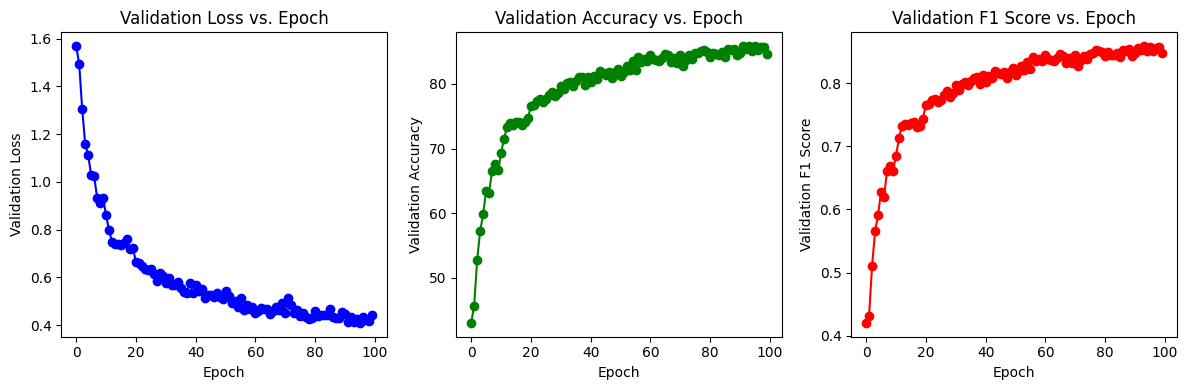

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(val_losses, 'bo-')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Epoch')

plt.subplot(1, 3, 2)
plt.plot(val_accs, 'go-')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epoch')

plt.subplot(1, 3, 3)
plt.plot(val_f1s, 'ro-')
plt.xlabel('Epoch')
plt.ylabel('Validation F1 Score')
plt.title('Validation F1 Score vs. Epoch')

plt.tight_layout()
plt.show()